In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir("/content/drive/My Drive/UMass/CS685")

In [ ]:
!pip install transformers
!pip install datasets
!pip install pytorch_pretrained_bert

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 41.3 MB/s 
     |████████████████████████████████| 3.3 MB 39.3 MB/s 
     |████████████████████████████████| 61 kB 469 kB/s 
     |████████████████████████████████| 895 kB 38.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 298 kB 5.2 MB/s 
     |████████████████████████████████| 243 kB 41.9 MB/s 
     |████████████████████████████████| 132 kB 49.9 MB/s 
     |████████████████████████████████| 1.1 MB 36.6 MB/s 
     |████████████████████████████████| 271 kB 50.1 MB/s 
     |████████████████████████████████| 160 kB 46.1 MB/s 
     |████████████████████████████████| 192 kB 52.0 MB/s 
     |████████████████████████████████| 123 kB 5.6 MB/s 
     |████████████████████████████████| 131 kB 42.5 MB/s 
     |████████████████████████████████| 79 k

In [ ]:
from datasets import load_dataset
med_dialog = load_dataset("medical_dialog", "en", data_dir="./Medical-Dialogue-Dataset-English")
covid_dialog = load_dataset("covid_qa_ucsd", "en", data_dir="./" )

Downloading:   0%|          | 0.00/3.82k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/913 [00:00<?, ?B/s]

Using custom data configuration en-7ad5e2a1147398cb


0 examples [00:00, ? examples/s]

Dataset medical_dialog downloaded and prepared to /root/.cache/huggingface/datasets/medical_dialog/en-7ad5e2a1147398cb/1.0.0/6b4b5348ad77903e71465d9910a30b9ec05dbeed9cb6b45349556a287ce42bab. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/3.49k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/805 [00:00<?, ?B/s]

Using custom data configuration en-data_dir=.%2F


0 examples [00:00, ? examples/s]

Dataset covid_qa_ucsd downloaded and prepared to /root/.cache/huggingface/datasets/covid_qa_ucsd/en-data_dir=.%2F/1.0.0/2a15b6e8fdc7cee91951d8f20ac2b26ede79fbef988919fbde22dbb97bf4df81. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

In [ ]:
cd_df = covid_dialog['train'].to_pandas()

In [ ]:
print(cd_df["dialogue_turns"])

0      {'speaker': [0, 1, 0, 1], 'utterance': ['I hav...
1      {'speaker': [0, 1, 0, 1, 0, 1, 0, 1], 'utteran...
2      {'speaker': [0, 1], 'utterance': ['Can Coronav...
3      {'speaker': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...
4      {'speaker': [0, 1], 'utterance': ['Does COVID-...
                             ...                        
567    {'speaker': [0, 1], 'utterance': ['If I get co...
568    {'speaker': [0, 1], 'utterance': ['I was on a ...
569    {'speaker': [0, 1], 'utterance': ['My son has ...
570    {'speaker': [0, 1], 'utterance': ['Can coronav...
571    {'speaker': [0, 1], 'utterance': ['Good day,  ...
Name: dialogue_turns, Length: 572, dtype: object


In [ ]:
L = [1,2,3,4]
for i in range(0,len(L),2):
  print(i)

0
2


In [ ]:
# Here we have only text 
text = []
for dial in cd_df["dialogue_turns"]:
  u = dial["utterance"]
  for i in range(0,len(u),2):
    pq = u[i:i+2]
    text.append(['<|endoftext|>'.join(pq)])
qa_df = pd.DataFrame(text, columns=["text"])

In [ ]:
print(len(qa_df))

583


In [ ]:
qa_df["text"][0]

'I have cough with no travel history. Is this a symptom of Covid-19?Hello doctor, I get a cough for the last few days, which is heavy during night times. No raise in temperature but feeling tired with no travel history. No contact with any Covid-19 persons. It has been four to five days and has drunk a lot of Benadryl and took Paracetamol too. Doctors have shut the OP so do not know what to do? Please help.<|endoftext|>Hello, I understand your concern. I just have a few more questions.Does your cough has phlegm? Any other symptoms like difficulty breathing? Any other medical condition such as asthma, hypertension? Are you a smoker? Alcoholic beverage drinker?'

In [ ]:
# Note: We may want to do prefix masked lm and not just generate the whole sequence
# We should probably truncate sequences on LHS
# It might also be good to split sentences with special doctor patient tokens.

In [ ]:
print(qa_df)

                                                  text
0    I have cough with no travel history. Is this a...
1    Thank you doctor,I have phlegm but not a lot. ...
2    I have a little fever with no history of forei...
3    Thank you doctor,After doing all these I can u...
4    Thank you doctor,As per your guidelines, I hav...
..                                                 ...
578  If I get coronavirus, are there ways to avoid ...
579  I was on a plane on March 8th have been home e...
580  My son has a fever, I am concerned due to the ...
581  Can coronavirus symptoms be mild for some peop...
582  Good day,  I am 29 weeks pregnant and my profe...

[583 rows x 1 columns]


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AdamW, GPT2LMHeadModel, GPT2DoubleHeadsModel, GPT2TokenizerFast, GPT2Config, BertTokenizer

from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions
from transformers.models.gpt2.modeling_gpt2 import GPT2DoubleHeadsModelOutput
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from pytorch_pretrained_bert.modeling_gpt2 import GPT2PreTrainedModel, GPT2MultipleChoiceHead, GPT2Model, GPT2LMHead, Attention, Block, \
    LayerNorm, MLP

In [ ]:
import os
import time
import datetime
# from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
text = qa_df.text.copy()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


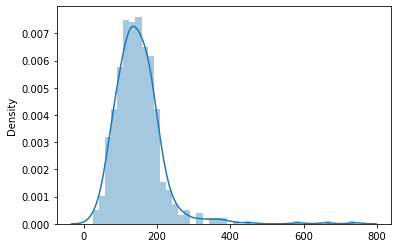

In [ ]:
doc_lengths = []

for bio in text:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)
             

In [ ]:
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small")


In [ ]:
batch_size = 2
tokenizer.pad_token = tokenizer.eos_token
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer(txt + tokenizer.eos_token, truncation=True, max_length=max_length, padding="max_length")
      
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [ ]:
dataset = GPT2Dataset(text, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  524 training samples
   59 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

In [ ]:
# I'm not really doing anything with the config buheret
# configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
# model = GPT2LMHeadModel.from_pretrained("microsoft/DialoGPT-small")
# model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
# if torch.cuda.is_available() and useCuda:
device = torch.device("cuda")
model.cuda()
# else:
#   device = torch.device("cpu")

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100


In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))
    

In [ ]:
print(model.device)

cuda:0


In [ ]:
total_t0 = time.time()

training_stats = []

# model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
  
        model.zero_grad()        

        outputs = model(b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    # bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    262. Loss: 0.7802261710166931.   Elapsed: 0:01:44.
0: !


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    262. Loss: 0.35679879784584045.   Elapsed: 0:03:29.
0: ,,

  Average training loss: 0.46
  Training epoch took: 0:04:34

Running Validation...
  Validation Loss: 0.66
  Validation took: 0:00:10

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    262. Loss: 0.4648677408695221.   Elapsed: 0:01:44.
0:  to me. Throat is sore and dry. Not sure if I have a need for an asthavent pump yet. Chest is hot.Not sure if I have a need for an asthavent pump yet. Throat is sore and dry. Not sure if I have a need for an asthavent pump yet. Chest is hot.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    262. Loss: 0.3023647665977478.   Elapsed: 0:03:30.
0:  am i at risk for covid 19 if i get the virus, because i have type 1 diabetes? what are my chances of getting it? i am 19 but i was in france?Am i at risk for covid 19 if i get the virus, because i have type 1 diabetes? what are my chances of getting it? i am 19 but i was in france?

  Average training loss: 0.34
  Training epoch took: 0:04:35

Running Validation...
  Validation Loss: 0.72
  Validation took: 0:00:10

======== Epoch 3 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    262. Loss: 0.10363274812698364.   Elapsed: 0:01:44.
0: ’s a bit late to call someone on the phone if they say the word not a local emergency.   And what are the risks of covid19? Any information on that?It’s a bit late to call someone on the phone if they say the word not a local emergency.  And what are the risks of covid19? Any information on that?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    262. Loss: 0.10688012093305588.   Elapsed: 0:03:30.
0: .Hi, I came into contact with someone who tested positive for Covid-19 but we suspect we may have another person who is showing symptoms. Let's go for a test if possible.If two of us have symptoms, there is no way to know.Take care

  Average training loss: 0.21
  Training epoch took: 0:04:35

Running Validation...
  Validation Loss: 0.82
  Validation took: 0:00:10

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    262. Loss: 0.2443551868200302.   Elapsed: 0:01:44.
0: ?Covid 19. Stay at home, monitor your temperature, drink lots of liquids, take Mucinex 5-7 and zinc if high ANC and IRRAN (medications needed), get exercise, IF get test. IF get test.Can you contact any of the coronavirus? I am unaware of any contact with the virus.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    262. Loss: 0.11837414652109146.   Elapsed: 0:03:30.
0:  am IH should I get tested for covid 19? Am IH should I get tested for covid 19? Am IH should I get tested for covid 19? Am IH should I get tested for covid 19? Am IH should I get tested for covid 19?

  Average training loss: 0.12
  Training epoch took: 0:04:35

Running Validation...
  Validation Loss: 0.96
  Validation took: 0:00:10

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    262. Loss: 0.06259432435035706.   Elapsed: 0:01:44.
0:  it is true (or a myth) that coronavirus will not survive hotter climates. As summer approaches, is it expected to reduce in tropical summers at least.Is it true (or a myth) that coronavirus will not survive hotter climates. As summer approaches, is it expected to reduce in tropical summers at least.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    262. Loss: 0.06675220280885696.   Elapsed: 0:03:29.
0: ’s the only way to know if the symptoms are bothersome, serious, or persistent?How many tablets of Azithromycin to be taken?’s the only way to know if the symptoms are bothersome, serious, or persistent?

  Average training loss: 0.07
  Training epoch took: 0:04:34

Running Validation...
  Validation Loss: 1.11
  Validation took: 0:00:10

Training complete!
Total training took 0:23:43 (h:mm:ss)


In [ ]:
import pandas as pd
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats


,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.46,0.66,0:04:34,0:00:10
2,0.34,0.72,0:04:35,0:00:10
3,0.21,0.82,0:04:35,0:00:10
4,0.12,0.96,0:04:35,0:00:10
5,0.07,1.11,0:04:34,0:00:10


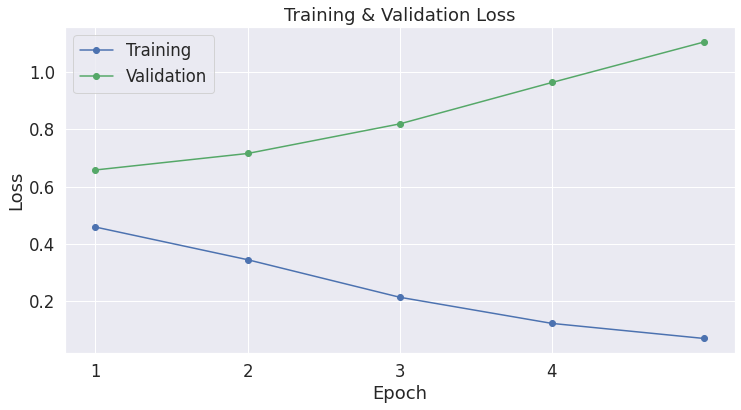

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50257, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [ ]:
step = 0
while True:
    context = input(">> User:")
    if context == "I am done talking":
      print("DoctorBot: Ok bye bye")
      break
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids1 = tokenizer(context + tokenizer.eos_token, return_tensors='pt').input_ids

    # append the new user input tokens to the chat history
    bot_input_ids1 = torch.cat([chat_history_ids1, new_user_input_ids1], dim=-1) if step > 0 else new_user_input_ids1
    bot_input_ids1 = bot_input_ids1.cuda()
    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids1 = model.generate(bot_input_ids1, max_length=1000, return_dict=True)
    step += 1
    # pretty print last ouput tokens from bot
    print("DoctorBot: {}".format(tokenizer.decode(chat_history_ids1[:, bot_input_ids1.shape[-1]:][0], skip_special_tokens=True)))

>> User:Hello


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


DialoGPT: Hello and Welcome to ‘Ask A Doctor’ service. I have reviewed your query and here is my advice. Yes, you are right. I should definitely consult a doctor. Thanks.


KeyboardInterrupt: ignored

In [ ]:
print(model.device)

print(bot_input_ids1.device)

# Can't be different

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


In [1]:
!git branch
  

fatal: not a git repository (or any of the parent directories): .git
